In [1]:
# Cell 2: imports & device & seed
import os, time, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import umap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms, models

print('Torch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)


2025-11-17 17:54:33.415045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763402073.662850      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763402073.727903      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Torch version: 2.6.0+cu124
Device: cuda


In [2]:
# Cell 3: Set your data path and verify
DATA_DIR = '/kaggle/input/betel/Controlled Environment'  # <-- change if different
assert os.path.exists(DATA_DIR), f"DATA_DIR not found: {DATA_DIR}"
print('Data dir OK:', DATA_DIR)


Data dir OK: /kaggle/input/betel/Controlled Environment


In [3]:
# Cell 4: augmentation recipes (SimCLR) and eval transform
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=23, sigma=(0.1,2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

print('Transforms ready.')


Transforms ready.


In [4]:
# Cell 5: SimCLR Dataset wrapper (returns two augmented views)
from torchvision.datasets import ImageFolder
from PIL import Image

class SimCLRDataset(ImageFolder):
    def __init__(self, root, transform):
        super().__init__(root, transform=None)
        self.transform = transform
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2

full_dataset = SimCLRDataset(DATA_DIR, transform=simclr_transform)
print('Total samples (for pretraining):', len(full_dataset))


Total samples (for pretraining): 893


In [5]:
# Cell 6: split and dataloaders for pretraining
indices = list(range(len(full_dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.1, random_state=seed)
train_ds = torch.utils.data.Subset(full_dataset, train_idx)
val_ds   = torch.utils.data.Subset(full_dataset, val_idx)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print('Pretrain train samples:', len(train_ds), 'val samples:', len(val_ds))


Pretrain train samples: 803 val samples: 90


In [6]:
# Cell 7: build encoder (ResNet-18) and projection head
base_encoder = models.resnet18(pretrained=False)
num_ftrs = base_encoder.fc.in_features
base_encoder.fc = nn.Identity()
encoder = base_encoder.to(device)

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, hidden_dim=512, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

proj_head = ProjectionHead(num_ftrs).to(device)
print('Encoder and projection head ready. num_ftrs=', num_ftrs)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Encoder and projection head ready. num_ftrs= 512


In [7]:
# Cell 8: NT-Xent loss implementation
import torch.nn.functional as F

def nt_xent_loss(z1, z2, temperature=0.5):
    z = torch.cat([z1, z2], dim=0)           # (2N, D)
    z = F.normalize(z, dim=1)
    sim = torch.matmul(z, z.T)               # (2N, 2N)
    N = z1.size(0)
    mask = torch.eye(2*N, device=z.device).bool()
    sim = sim / temperature
    exp_sim = torch.exp(sim)
    exp_sim = exp_sim.masked_fill(mask, 0)
    # positive similarities: between i and i+N
    pos = torch.exp((F.cosine_similarity(z1, z2, dim=1)) / temperature)
    pos = torch.cat([pos, pos], dim=0)
    denom = exp_sim.sum(dim=1)
    loss = -torch.log(pos / denom)
    return loss.mean()


In [8]:
# Cell 9: optimizer, optional AMP scaler, helper to save frozen encoder
params = list(encoder.parameters()) + list(proj_head.parameters())
opt = torch.optim.Adam(params, lr=3e-4, weight_decay=1e-6)
scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

def save_frozen_encoder(encoder, path='simclr_encoder_frozen.pth'):
    torch.save(encoder.state_dict(), path)
    print('Saved encoder to', path)


/tmp/ipykernel_19/1993587253.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None


In [9]:
# Cell 10: SimCLR pretraining loop (adjust epochs for your budget)
epochs = 20  # change as needed
best_val_loss = 1e9
start_time = time.time()

for epoch in range(epochs):
    encoder.train(); proj_head.train()
    running_loss = 0.0
    for x1, x2 in train_loader:
        x1 = x1.to(device); x2 = x2.to(device)
        # use autocast for AMP if available
        if scaler is not None:
            with torch.cuda.amp.autocast():
                h1 = encoder(x1); h2 = encoder(x2)
                z1 = proj_head(h1); z2 = proj_head(h2)
                loss = nt_xent_loss(z1, z2, temperature=0.5)
            opt.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
        else:
            h1 = encoder(x1); h2 = encoder(x2)
            z1 = proj_head(h1); z2 = proj_head(h2)
            loss = nt_xent_loss(z1, z2, temperature=0.5)
            opt.zero_grad(); loss.backward(); opt.step()
        running_loss += loss.item() * x1.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)

    # validation loss
    encoder.eval(); proj_head.eval()
    val_loss = 0.0
    with torch.no_grad():
        for vx1, vx2 in val_loader:
            vx1 = vx1.to(device); vx2 = vx2.to(device)
            vh1 = encoder(vx1); vh2 = encoder(vx2)
            vz1 = proj_head(vh1); vz2 = proj_head(vh2)
            l = nt_xent_loss(vz1, vz2)
            val_loss += l.item() * vx1.size(0)
    val_loss = val_loss / len(val_loader.dataset)
    elapsed = (time.time() - start_time) / 60.0
    print(f'Epoch {epoch+1}/{epochs} train_loss={epoch_loss:.4f} val_loss={val_loss:.4f} elapsed={elapsed:.2f}m')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_frozen_encoder(encoder, path='simclr_encoder_best.pth')

# final save
save_frozen_encoder(encoder, path='simclr_encoder_frozen.pth')


/tmp/ipykernel_19/3049957772.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/20 train_loss=4.6169 val_loss=4.1254 elapsed=4.53m
Saved encoder to simclr_encoder_best.pth
Epoch 2/20 train_loss=4.4908 val_loss=4.2463 elapsed=8.91m
Epoch 3/20 train_loss=4.4984 val_loss=4.1370 elapsed=13.42m
Epoch 4/20 train_loss=4.4980 val_loss=4.2158 elapsed=17.92m
Epoch 5/20 train_loss=4.4779 val_loss=4.1498 elapsed=22.37m
Epoch 6/20 train_loss=4.4306 val_loss=4.0031 elapsed=26.82m
Saved encoder to simclr_encoder_best.pth
Epoch 7/20 train_loss=4.4266 val_loss=4.0810 elapsed=31.69m
Epoch 8/20 train_loss=4.4009 val_loss=4.1039 elapsed=36.39m
Epoch 9/20 train_loss=4.3543 val_loss=4.0241 elapsed=41.25m
Epoch 10/20 train_loss=4.3957 val_loss=4.0105 elapsed=45.97m
Epoch 11/20 train_loss=4.3054 val_loss=4.0490 elapsed=50.55m
Epoch 12/20 train_loss=4.3308 val_loss=3.9631 elapsed=55.16m
Saved encoder to simclr_encoder_best.pth
Epoch 13/20 train_loss=4.3873 val_loss=4.0660 elapsed=60.00m
Epoch 14/20 train_loss=4.2840 val_loss=3.9761 elapsed=64.85m
Epoch 15/20 train_loss=4.2810 val_

In [10]:
# Cell 11: Labeled ImageFolder + splits for downstream
labeled_ds = ImageFolder(DATA_DIR, transform=eval_transform)
classes = labeled_ds.classes
n_classes = len(classes)
print('Classes:', classes, 'n_classes=', n_classes)

indices = list(range(len(labeled_ds)))
train_idx, test_idx = train_test_split(indices, test_size=0.2,
                                       stratify=[y for _,y in labeled_ds.samples],
                                       random_state=seed)
train_ds = torch.utils.data.Subset(labeled_ds, train_idx)
test_ds  = torch.utils.data.Subset(labeled_ds, test_idx)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=4)
print('Downstream train/test samples:', len(train_ds), len(test_ds))


Classes: ['Diseased', 'Dried', 'Healthy'] n_classes= 3
Downstream train/test samples: 714 179


In [11]:
# Cell 12: linear probe (freeze encoder, train single linear layer)
# If restarted kernel: load encoder weights
# encoder.load_state_dict(torch.load('simclr_encoder_frozen.pth'))
encoder.eval()
for p in encoder.parameters(): p.requires_grad = False

linear_head = nn.Linear(num_ftrs, n_classes).to(device)
opt_lp = torch.optim.Adam(linear_head.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

lp_epochs = 20
for epoch in range(lp_epochs):
    linear_head.train()
    running_loss = 0.0
    for x,y in train_loader:
        x = x.to(device); y = y.to(device)
        with torch.no_grad():
            feats = encoder(x)
        logits = linear_head(feats)
        loss = loss_fn(logits, y)
        opt_lp.zero_grad(); loss.backward(); opt_lp.step()
        running_loss += loss.item() * x.size(0)
    print(f'LP Epoch {epoch+1}/{lp_epochs} loss={running_loss/len(train_loader.dataset):.4f}')

# Evaluate linear probe
linear_head.eval()
lp_preds=[]; lp_labels=[]; lp_probs=[]
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device)
        feats = encoder(x)
        logits = linear_head(feats)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()
        lp_preds.extend(preds); lp_labels.extend(y.numpy()); lp_probs.extend(probs)

print('Linear probe report:')
print(classification_report(lp_labels, lp_preds, target_names=classes))


LP Epoch 1/20 loss=0.7568
LP Epoch 2/20 loss=0.4145
LP Epoch 3/20 loss=0.3855
LP Epoch 4/20 loss=0.3703
LP Epoch 5/20 loss=0.3601
LP Epoch 6/20 loss=0.3515
LP Epoch 7/20 loss=0.3505
LP Epoch 8/20 loss=0.3447
LP Epoch 9/20 loss=0.3392
LP Epoch 10/20 loss=0.3377
LP Epoch 11/20 loss=0.3318
LP Epoch 12/20 loss=0.3334
LP Epoch 13/20 loss=0.3273
LP Epoch 14/20 loss=0.3271
LP Epoch 15/20 loss=0.3217
LP Epoch 16/20 loss=0.3214
LP Epoch 17/20 loss=0.3266
LP Epoch 18/20 loss=0.3301
LP Epoch 19/20 loss=0.3176
LP Epoch 20/20 loss=0.3152
Linear probe report:
              precision    recall  f1-score   support

    Diseased       0.79      0.68      0.73        44
       Dried       0.96      0.99      0.97        68
     Healthy       0.83      0.88      0.86        67

    accuracy                           0.87       179
   macro avg       0.86      0.85      0.85       179
weighted avg       0.87      0.87      0.87       179



In [12]:
# Cell 13: extract embeddings for all images (to use with shallow heads)
encoder.eval()
embeddings = []
labels = []
loader = DataLoader(labeled_ds, batch_size=64, shuffle=False, num_workers=4)
with torch.no_grad():
    for x,y in loader:
        x = x.to(device)
        feats = encoder(x).cpu().numpy()
        embeddings.append(feats); labels.append(y.numpy())
emb = np.vstack(embeddings)
lbl = np.concatenate(labels)
print('Embeddings shape:', emb.shape)
# Align train/test subsets using train_idx/test_idx from earlier
Xtr = emb[train_idx]; Xte = emb[test_idx]; ytr = lbl[train_idx]; yte = lbl[test_idx]


Embeddings shape: (893, 512)


In [13]:
# Cell 14: sklearn classifiers on frozen features
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

classifiers = {
    'SVM': SVC(kernel='rbf', probability=True, random_state=seed),
    'DecisionTree': DecisionTreeClassifier(random_state=seed),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=seed),
    'MLP': MLPClassifier(hidden_layer_sizes=(256,), max_iter=300, random_state=seed)
}

shallow_results = {}
for name, clf in classifiers.items():
    clf.fit(Xtr, ytr)
    acc = clf.score(Xte, yte)
    preds = clf.predict(Xte)
    report = classification_report(yte, preds, target_names=classes, output_dict=True)
    shallow_results[name] = {'acc': acc, 'report': report}
    print(f'{name} acc = {acc:.4f}')


SVM acc = 0.8492
DecisionTree acc = 0.8156
RandomForest acc = 0.8715
MLP acc = 0.8603


In [14]:
# Cell 15: fine-tune entire encoder + linear head
for p in encoder.parameters(): p.requires_grad = True
head = nn.Linear(num_ftrs, n_classes).to(device)
opt_ft = torch.optim.Adam(list(encoder.parameters()) + list(head.parameters()), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

ft_epochs = 20
for epoch in range(ft_epochs):
    encoder.train(); head.train()
    running_loss = 0.0
    for x,y in train_loader:
        x = x.to(device); y = y.to(device)
        feats = encoder(x)
        logits = head(feats)
        loss = loss_fn(logits, y)
        opt_ft.zero_grad(); loss.backward(); opt_ft.step()
        running_loss += loss.item() * x.size(0)
    print(f'FT Epoch {epoch+1}/{ft_epochs} loss={running_loss/len(train_loader.dataset):.4f}')

# Evaluate fine-tuned model
encoder.eval(); head.eval()
ft_preds=[]; ft_labels=[]; ft_probs=[]
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device)
        logits = head(encoder(x))
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = logits.argmax(dim=1).cpu().numpy()
        ft_preds.extend(preds); ft_labels.extend(y.numpy()); ft_probs.extend(probs)

print('Fine-tune report:')
print(classification_report(ft_labels, ft_preds, target_names=classes))


FT Epoch 1/20 loss=0.4574
FT Epoch 2/20 loss=0.2710
FT Epoch 3/20 loss=0.2172
FT Epoch 4/20 loss=0.1823
FT Epoch 5/20 loss=0.1655
FT Epoch 6/20 loss=0.1280
FT Epoch 7/20 loss=0.1316
FT Epoch 8/20 loss=0.1221
FT Epoch 9/20 loss=0.0802
FT Epoch 10/20 loss=0.0928
FT Epoch 11/20 loss=0.0692
FT Epoch 12/20 loss=0.0373
FT Epoch 13/20 loss=0.0290
FT Epoch 14/20 loss=0.0249
FT Epoch 15/20 loss=0.0510
FT Epoch 16/20 loss=0.0509
FT Epoch 17/20 loss=0.0350
FT Epoch 18/20 loss=0.0520
FT Epoch 19/20 loss=0.0272
FT Epoch 20/20 loss=0.0238
Fine-tune report:
              precision    recall  f1-score   support

    Diseased       1.00      0.27      0.43        44
       Dried       0.96      1.00      0.98        68
     Healthy       0.70      1.00      0.82        67

    accuracy                           0.82       179
   macro avg       0.89      0.76      0.74       179
weighted avg       0.87      0.82      0.78       179



/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


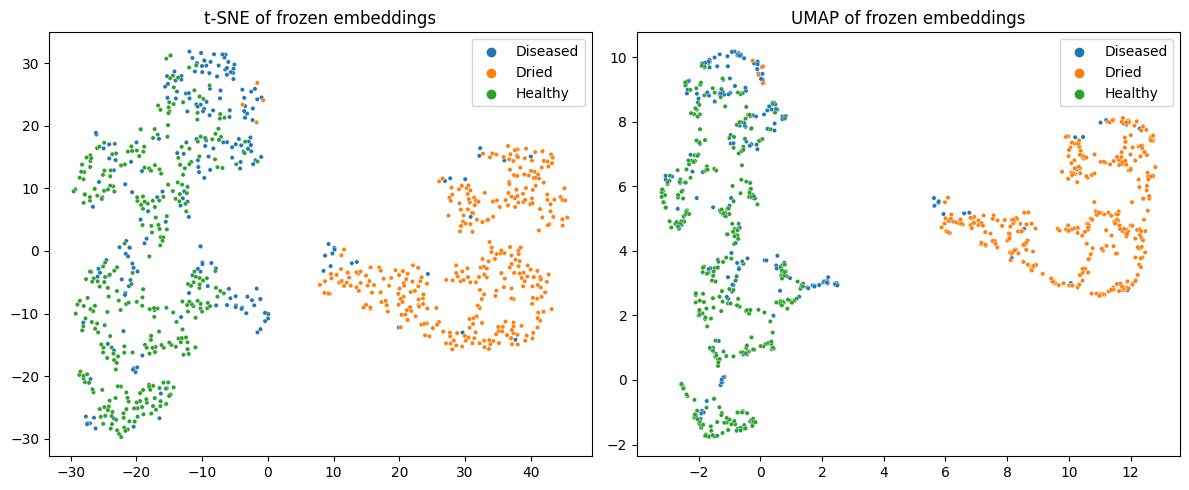

Silhouette score (embeddings): 0.2913


In [15]:
# --- Patch UMAP's internal check_array directly ---
import umap.umap_
umap.umap_.check_array = lambda X, **kwargs: X   # <--- FINAL FIX

# Convert embeddings to float32
emb32 = emb.astype(np.float32)

# PCA
pca50 = PCA(n_components=50).fit_transform(emb32)

# t-SNE
tsne2 = TSNE(
    n_components=2,
    perplexity=30,
    n_iter=1000,
    init='pca',
    random_state=seed
).fit_transform(pca50)

# UMAP (now safe because check_array is bypassed)
umap2 = umap.UMAP(
    n_components=2,
    random_state=seed
).fit_transform(emb32)

# Plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('t-SNE of frozen embeddings')
sns.scatterplot(
    x=tsne2[:,0], y=tsne2[:,1],
    hue=[classes[i] for i in lbl],
    legend='brief', s=10
)

plt.subplot(1,2,2)
plt.title('UMAP of frozen embeddings')
sns.scatterplot(
    x=umap2[:,0], y=umap2[:,1],
    hue=[classes[i] for i in lbl],
    legend='brief', s=10
)

plt.tight_layout()
plt.show()

# Silhouette
sil = silhouette_score(pca50, lbl)
print(f"Silhouette score (embeddings): {sil:.4f}")


Per-class accuracy (fine-tuned):
Healthy: 1.0000
Diseased: 0.2727
Dried: 1.0000


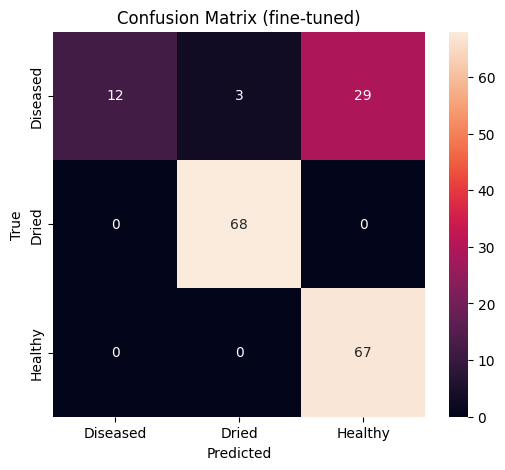

ROC-AUC (fine-tuned): 0.9967431062580316


In [16]:
# Cell 17: metrics & confusion matrix for fine-tuned results
# per-class accuracy
per_class_acc = defaultdict(lambda: [0,0])
for true, pred in zip(ft_labels, ft_preds):
    per_class_acc[classes[true]][1] += 1
    if true == pred: per_class_acc[classes[true]][0] += 1

print('Per-class accuracy (fine-tuned):')
for k,v in per_class_acc.items():
    acc = v[0]/v[1] if v[1]>0 else 0
    print(f'{k}: {acc:.4f}')

# confusion matrix
cm = confusion_matrix(ft_labels, ft_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix (fine-tuned)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

# ROC-AUC (one-vs-rest) using ft_probs
try:
    y_true_bin = label_binarize(ft_labels, classes=list(range(n_classes)))
    roc = roc_auc_score(y_true_bin, np.array(ft_probs), average='macro', multi_class='ovr')
    print('ROC-AUC (fine-tuned):', roc)
except Exception as e:
    print('ROC-AUC compute failed:', e)


In [17]:
# Cell 18: Learning curves
print('If you want training/validation curves logged, integrate TensorBoard or CSV logging in training loops.')
# Example: collect per-epoch losses in lists during training loops and plot them here.


If you want training/validation curves logged, integrate TensorBoard or CSV logging in training loops.


In [18]:
# Cell 19: k-NN accuracy in embedding space and label-efficiency curves
for k in [1,5,20]:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtr, ytr)
    acc = knn.score(Xte, yte)
    print(f'k-NN (k={k}) accuracy = {acc:.4f}')

fractions = [0.01, 0.05, 0.1, 0.25, 0.5]
le_results = {}
for f in fractions:
    n = max(1, int(len(Xtr)*f))
    idx = np.random.choice(len(Xtr), n, replace=False)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(Xtr[idx], ytr[idx])
    le_results[f] = knn.score(Xte, yte)

print('Label-efficiency (fraction -> kNN acc):')
for f,v in le_results.items():
    print(f'{int(f*100)}% -> {v:.4f}')


k-NN (k=1) accuracy = 0.8212
k-NN (k=5) accuracy = 0.8547
k-NN (k=20) accuracy = 0.8324
Label-efficiency (fraction -> kNN acc):
1% -> 0.5810
5% -> 0.8380
10% -> 0.7933
25% -> 0.8324
50% -> 0.8268


In [19]:
# Cell 20: GFLOPs (optional) and timing & save artifacts
try:
    from ptflops import get_model_complexity_info
    macs, params = get_model_complexity_info(encoder, (3,224,224), as_strings=True, print_per_layer_stat=False)
    print('MACs:', macs, 'Params:', params)
except Exception as e:
    print('ptflops not available or failed:', e)

# Forward timing sample
x = torch.randn(8,3,224,224).to(device)
encoder.eval()
with torch.no_grad():
    t0 = time.time(); _ = encoder(x); t1 = time.time()
print('Forward time (8 samples):', (t1-t0), 'sec')

# Save embeddings, labels, and models
np.save('embeddings.npy', emb)
np.save('labels.npy', lbl)
torch.save(linear_head.state_dict(), 'simclr_linear_head.pth')
torch.save(head.state_dict(), 'simclr_finetune_head.pth')
# encoder saved earlier as simclr_encoder_best.pth / simclr_encoder_frozen.pth

# Summary (example - fill with actuals as desired)
summary = {
    'method':'SimCLR',
    'linear_probe_acc': accuracy_score(lp_labels, lp_preds) if 'lp_labels' in globals() else None,
    'fine_tune_acc': accuracy_score(ft_labels, ft_preds) if 'ft_labels' in globals() else None,
    'silhouette': float(sil) if 'sil' in globals() else None
}
print('Summary (partial):', summary)


ptflops not available or failed: No module named 'ptflops'
Forward time (8 samples): 0.01404714584350586 sec
Summary (partial): {'method': 'SimCLR', 'linear_probe_acc': 0.8715083798882681, 'fine_tune_acc': 0.8212290502793296, 'silhouette': 0.29134416580200195}
